**3.1 Open Exploration Group 11**
**imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import os


**EMA_workbench and setup**

In [2]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
    save_results,
    load_results
)

from ema_workbench.analysis import prim
from dike_model_function import DikeNetwork  # Import the DikeNetwork model
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

Choose either problem formulation 2 (all actors) or 6 Gelderland


In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

"""
    Parameters
    ----------
    problem_formulation_id : int {0, ..., 6}
                             problem formulations differ with respect to the objectives
                             0: Total cost, and casualties
                             1: Expected damages, costs, and casualties
                             2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
                             3: costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
                             4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
                             5: disaggregate over time and space
                             6: Same as 3 but only aggregated for Gelderland, NOTE Expected annual damage only represents Gelderland

    """
problem_formulation = 6
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [4]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [6]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x0000020541C6ACB0>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x0000020541C6ACB0>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x0000020541C6ACB0>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x0000020541C6ACB0>)
ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x0000020541C6ACB0>)
ScalarOutcome('A.3_Expected Number of Deaths', variable_name=('A.3_Expected Number of Deaths',), function=<function sum_over at 0x0000020541C6ACB0>)
ScalarOutcome('Expected Evacuation Costs', variable_name=('Expected Evacu

Use latinhypercube sampling for even spread in uncertainties. n_processes= -1 used to maximize computational power without crashing pc. Mogelijk versimpelen, kan evt handig zijn later

In [7]:
def runner(n_scenarios=None, scenarios=None, n_policies=None, policies=None,
           sampler=Samplers.LHS, problem_formulation=6, overwrite=False):
    """
    Run the model with multiprocessing using flexible scenario and policy input.

    :param n_scenarios: Number of scenarios to generate (used if 'scenarios' is not provided)
    :param scenarios: Optional list/DataFrame of predefined scenarios
    :param n_policies: Number of policies to sample (used if 'policies' is not provided)
    :param policies: Optional list of predefined Policy objects
    :param sampler: Sampling method for uncertainties
    :param problem_formulation: Integer tag for problem setup (used in filename)
    :return: Results from the model evaluation
    """
    # Construct a flexible identifier for caching
    scenario_tag = f"{len(scenarios)}sc" if scenarios is not None else f"{n_scenarios}sc"
    policy_tag = f"{len(policies)}pf" if policies is not None else f"{n_policies}pf"
    filename = f'data/test_runs/open_expl_{scenario_tag}_{policy_tag}_pf_{problem_formulation}.tar.gz'

    if os.path.exists(filename) and overwrite == False:
        print(f"Loading existing results from {filename}")
        results = load_results(filename)
    else:
        with MultiprocessingEvaluator(dike_model, n_processes=-1) as evaluator:
            results = evaluator.perform_experiments(
                scenarios=scenarios if scenarios is not None else n_scenarios,
                policies=policies if policies is not None else n_policies,
                uncertainty_sampling=sampler
            )
        print(f"Saving results to {filename}")
        save_results(results, filename)

    return results


**No Policy Analysis**

In [8]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

#Do nothing
policies = [Policy(
        "policy 0",
        **dict(
            get_do_nothing_dict()
        )
    ),]


results_no_pl = runner(
    n_scenarios=1000, policies=policies,overwrite=True,)

[MainProcess/INFO] pool started with 15 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:26<00:00, 37.27it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to c:\Users\juliu\Documents\GitHub\MDM_project\final assignment\data\test_runs\open_expl_1000sc_1pf_pf_6.tar.gz


Saving results to data/test_runs/open_expl_1000sc_1pf_pf_6.tar.gz


In [9]:
# observing the simulation runs
experiments_no_pl, outcomes_no_pl = results_no_pl

In [10]:
experiments_no_pl

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,73,152.413303,1.0,0.446343,224.690091,10.0,0.636626,52.438367,10.0,0.885542,...,0,0,0,0,0,0,0,0,policy 0,dikesnet
1,47,258.189100,10.0,0.496541,118.548970,1.0,0.481775,252.757049,10.0,0.045585,...,0,0,0,0,0,0,0,1,policy 0,dikesnet
2,8,249.515535,10.0,0.401094,148.612315,1.5,0.730245,309.971462,1.5,0.590933,...,0,0,0,0,0,0,0,2,policy 0,dikesnet
3,121,32.945740,1.0,0.743210,34.219822,1.0,0.780985,274.054120,1.0,0.232801,...,0,0,0,0,0,0,0,3,policy 0,dikesnet
4,5,106.768112,10.0,0.386263,336.208642,1.0,0.769664,227.962513,10.0,0.346943,...,0,0,0,0,0,0,0,4,policy 0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,48,267.589154,1.0,0.379025,267.558865,10.0,0.934183,186.297888,10.0,0.450449,...,0,0,0,0,0,0,0,995,policy 0,dikesnet
996,71,124.232819,10.0,0.354481,177.072046,1.0,0.081784,267.157332,1.0,0.628627,...,0,0,0,0,0,0,0,996,policy 0,dikesnet
997,66,112.449295,1.5,0.286815,109.941503,10.0,0.508564,70.575293,1.0,0.718255,...,0,0,0,0,0,0,0,997,policy 0,dikesnet
998,5,346.327997,1.5,0.745994,218.072450,10.0,0.637631,32.000509,1.0,0.121315,...,0,0,0,0,0,0,0,998,policy 0,dikesnet


In [11]:
outcomes_no_pl = pd.DataFrame(outcomes_no_pl)
outcomes_no_pl

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,Expected Evacuation Costs,Expected Annual Damage,Expected Number of Deaths
0,6.056523e+08,0.357340,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,6.056523e+08,0.357340
1,2.235157e+08,0.154080,7.011380e+07,0.064223,2.095441e+09,3.456755,0.0,2.389070e+09,3.675058
2,1.053477e+09,0.670131,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,1.053477e+09,0.670131
3,2.634180e+06,0.001884,2.377839e+07,0.022892,1.313881e+09,2.223426,0.0,1.340294e+09,2.248202
4,1.441723e+09,0.831179,0.000000e+00,0.000000,1.756244e+08,0.262845,0.0,1.617347e+09,1.094024
...,...,...,...,...,...,...,...,...,...
995,1.636370e+09,0.819973,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,1.636370e+09,0.819973
996,2.670834e+09,1.516031,1.061122e+09,0.760286,0.000000e+00,0.000000,0.0,3.731955e+09,2.276317
997,3.489875e+09,1.840962,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,3.489875e+09,1.840962
998,0.000000e+00,0.000000,3.138310e+07,0.032991,1.870096e+09,3.417182,0.0,1.901479e+09,3.450173


**PRIM**

[MainProcess/INFO] 1000 points remaining, containing 100 cases of interest
[MainProcess/INFO] mean: 0.9827586206896551, mass: 0.058, coverage: 0.57, density: 0.9827586206896551 restricted_dimensions: 5


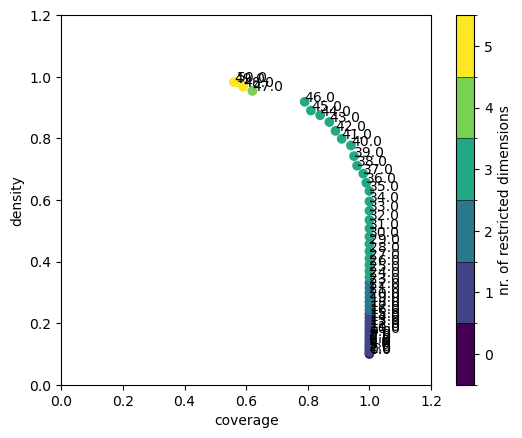

In [12]:
#andere modellen droppen niet scenario policy en model?
uncertainty_names = [u.name for u in uncertainties]
x_no_pl = experiments_no_pl[uncertainty_names]
threshold = 0.9
y_no_pl = outcomes_no_pl['Expected Annual Damage'] < np.percentile(outcomes_no_pl['Expected Annual Damage'], 10)
y_no_pl

prim_alg = prim.Prim(x_no_pl, y_no_pl, threshold=0.7)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

In [13]:
point = 45
box1.inspect(point)

coverage     0.81000
density      0.89011
id          45.00000
k           81.00000
mass         0.09100
mean         0.89011
n           91.00000
res_dim      3.00000
Name: 45, dtype: float64

             box 45                                 
                min       max      qp value qp value
A.1_pfail  0.631905  0.999030  2.699199e-27      NaN
A.3_pfail  0.602268  0.999393  2.665483e-25      NaN
A.2_pfail  0.356295  0.999773  5.473908e-10      NaN



[None]

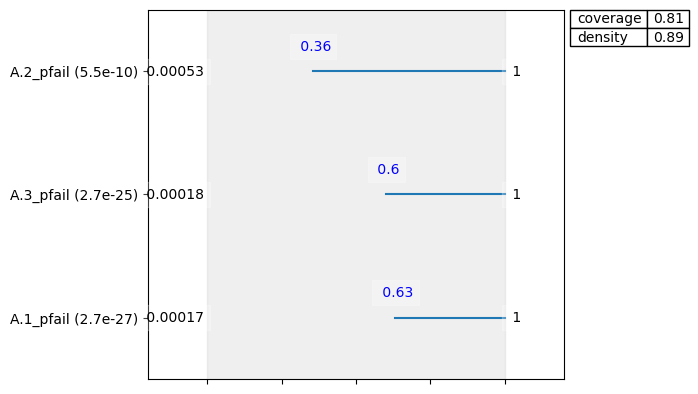

In [14]:
box1.inspect(point, style='graph')
plt.show()